In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

# Configurações para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

## Definindo as covariáveis

Iremos utilizar a covariável básica de trend, em conjunto com a indicadora mensal, e por fim, adicionar os lags de 1, 4 e 12 semanas, além disso, também iremos incluir as médias móveis e médias móveis exponencias de 4 e 12 semanas, e por fim, a volatilidade de 4 e 12 semanas.

Visto que a série temporal não apresenta sazonalidade anual, não iremos adicionar variáveis muito distantes no tempo.

In [2]:
# Carregando os dados originais
data = pd.read_csv("../data.csv")
data["week"] = pd.to_datetime(data["week"])
data_series = data.set_index("week")['volume']

# --- Definição de Atributos ---
df = pd.DataFrame({'volume': data_series})
df['trend'] = range(len(df))

# Dummies mensais
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True, prefix='mes')
dummy_cols = [col for col in df.columns if 'mes_' in col]
df[dummy_cols] = df[dummy_cols].astype(int)

# Lags
df['lag_1'] = df['volume'].shift(1)
df['lag_4'] = df['volume'].shift(4)
df['lag_12'] = df['volume'].shift(12)

# Médias Móveis (Simples e Exponencial)
df['volume_sma_4'] = df['volume'].rolling(window=4).mean()
df['volume_sma_12'] = df['volume'].rolling(window=12).mean()
df['volume_ema_4'] = df['volume'].ewm(span=4, adjust=False).mean()
df['volume_ema_12'] = df['volume'].ewm(span=12, adjust=False).mean()

# Desvio Padrão Móvel
df['volume_std_4'] = df['volume'].rolling(window=4).std()
df['volume_std_12'] = df['volume'].rolling(window=12).std()

df.dropna(inplace=True)

X = df.drop('volume', axis=1)
y = df['volume']

Definindo o conjunto de treinamento e teste:

In [3]:
# Divisão cronológica dos dados
train_size_full = len(data_series)
train_size_adjusted = int(train_size_full * 0.8) - 12

X_train, X_test = X.iloc[:train_size_adjusted], X.iloc[train_size_adjusted:]
y_train, y_test = y.iloc[:train_size_adjusted], y.iloc[train_size_adjusted:]

train_volume = data_series.iloc[: int(train_size_full * 0.8)]
test_volume = data_series.iloc[int(train_size_full * 0.8) :]

## Gerando as predições dos modelos

Considerando as covariáveis como grupos, para ver o desempenho de cada grupo de variáveis.

In [4]:
predictions = {}
models = {}

months_cols = [col for col in X.columns if 'mes_' in col]
lag_cols = ['lag_1', 'lag_4', 'lag_12']
ma_cols = ['volume_sma_4', 'volume_sma_12', 'volume_ema_4', 'volume_ema_12']
std_cols = ['volume_std_4', 'volume_std_12']

models_cols = {
    'Tendência': ['trend'],
    'Meses': months_cols,
    'Lags': lag_cols,
    'Médias Móveis': ma_cols,
    'Desvio Padrão Móvel': std_cols,
}

for model_name, cols in models_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [5]:
# Função para o Winkler Score
def winkler_score(y_true, lower, upper, alpha):
    score = np.where(
        y_true < lower,
        (upper - lower) + (2 / alpha) * (lower - y_true),
        np.where(
            y_true > upper,
            (upper - lower) + (2 / alpha) * (y_true - upper),
            (upper - lower),
        ),
    )
    return np.mean(score)


# Função para o Erro de Quantil
def quantile_score(y_true, quantile_forecast, p):
    error = y_true - quantile_forecast
    return np.mean(np.where(error >= 0, p * error, (p - 1) * error))


# Função para o CRPS de uma distribuição Normal
def crps_gaussian(y_true, mu, sigma):
    z = (y_true - mu) / sigma
    crps = sigma * (
        z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi)
    )
    return np.mean(crps)

## Analisando as métricas das predições dos grupos

In [6]:
intervals = {}
residuals_std = {}


def update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume, alpha=0.05
):
    processed_models = [res['Modelo'] for res in results_list]

    new_model_names = [
        name for name in models.keys() if name not in processed_models
    ]

    if not new_model_names:
        return pd.DataFrame(results_list).set_index('Modelo')

    for name in new_model_names:
        residuals_std[name] = models[name].resid.std()

    for name in new_model_names:
        forecast = predictions[name]
        sigma = residuals_std[name]
        z_score = norm.ppf(1 - alpha / 2)
        intervals[name] = {
            'lower': forecast - z_score * sigma,
            'upper': forecast + z_score * sigma,
        }

    # --- Cálculo das Métricas ---
    m = 12  # Sazonalidade para o scale do MASE
    scale = np.mean(np.abs(train_volume.diff(m).dropna()))
    quantiles_to_check = [0.1, 0.25, 0.5, 0.75, 0.9]

    for name in new_model_names:
        forecast = predictions[name]
        current_test_volume = test_volume[forecast.index]
        interval = intervals[name]
        sigma = residuals_std[name]

        # Métricas de erro pontual
        mae = mean_absolute_error(current_test_volume, forecast)
        rmse = np.sqrt(mean_squared_error(current_test_volume, forecast))
        mape = mean_absolute_percentage_error(current_test_volume, forecast)
        mase = mae / scale

        # Métricas probabilísticas
        winkler = winkler_score(
            current_test_volume, interval['lower'], interval['upper'], alpha
        )
        sigma_h = pd.Series(sigma, index=current_test_volume.index)
        crps = crps_gaussian(current_test_volume, forecast, sigma_h)

        # Métrica de quantil
        avg_quantile_loss = []
        for p in quantiles_to_check:
            quantile_forecast = norm.ppf(p, loc=forecast, scale=sigma_h)
            avg_quantile_loss.append(
                quantile_score(current_test_volume, quantile_forecast, p)
            )

        # Adiciona os resultados à lista
        results_list.append(
            {
                'Modelo': name,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape * 100,
                'MASE': mase,
                'Winkler Score': winkler,
                'Avg Quantile Score': np.mean(avg_quantile_loss),
                'CRPS': crps,
            }
        )

    return pd.DataFrame(results_list).set_index('Modelo')


results_list = []

results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas (Grupos de Covariáveis) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Médias Móveis,0.4293,0.5176,4.1745,0.3156,6.8800,0.1735,0.3474
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.5509,4.1116,32.5930,2.6104,72.6701,1.5079,3.0083
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Pelos resultados podemos observar que o modelo de médias móveis apresentou o melhor desempenho, seguido do modelo com lags, que performaram bem melhores do que o modelo básico com trend e volatiliade, e o modelo de indicadoras mensais foi o pior de todos.

## Analisando os parâmetros dos melhores modelos

In [7]:
models["Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     4386.
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          4.71e-114
Time:                        16:37:19   Log-Likelihood:                 28.231
No. Observations:                 108   AIC:                            -46.46
Df Residuals:                     103   BIC:                            -33.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.029      0.648      0.519      -0.039       0.077
volume_sma_4     -1.6452      0.103    -15.967      0.000      -1.850      -1.441
volume_sma_12    -0.4447      0.118     -3.756      0.000      -0.679      -0.210
volume_ema_4      3.0221      0.109     27.670      0.000       2.806       3.239
volume_ema_12     0.0632      0.150      0.422      0.674      -0.234       0.360
==============================================================================
Omnibus:                        9.536   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               14.665
Skew:                          -0.379   Prob(JB):                     0.000654
Kurtosis:                       4.639   Cond. No.                         74.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
models["Lags"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     510.7
Date:                Wed, 01 Oct 2025   Prob (F-statistic):           4.63e-62
Time:                        16:37:19   Log-Likelihood:                -100.72
No. Observations:                 108   AIC:                             209.4
Df Residuals:                     104   BIC:                             220.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1568      0.091      1.717      0.089      -0.024       0.338
lag_1          0.8982      0.057     15.719      0.000       0.785       1.011
lag_4          0.1660      0.072      2.321      0.022       0.024       0.308
lag_12        -0.1091      0.044     -2.505      0.014      -0.195      -0.023
==============================================================================
Omnibus:                        5.943   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                9.322
Skew:                          -0.079   Prob(JB):                      0.00946
Kurtosis:                       4.431   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vemos um problema no modelo de médias móveis, onde o parâmetro volume_ema_12 tem um p-valor alto, e seu intervalo de confiança inclui o zero, indicando que esse parâmetro não é estatisticamente significativo.

Levando isso em consideração, criaremos novos modelos removendo esse parâmetro e juntando mais grupos de variáveis para analisar o desempenho.

In [9]:
ma_cols.remove("volume_ema_12")

models_combined_cols = {
    "Lags + Médias Móveis": lag_cols + ma_cols,
    "Lags + Médias Móveis + Tendência": lag_cols + ma_cols + ['trend'],
    "Lags + Médias Móveis + Desvio Padrão": lag_cols + ma_cols + std_cols,
}

for model_name, cols in models_combined_cols.items():
    X_train_model = sm.add_constant(X_train[cols])
    X_test_model = sm.add_constant(X_test[cols])

    model = sm.OLS(y_train, X_train_model).fit()
    models[model_name] = model

    y_pred = model.predict(X_test_model)
    predictions[model_name] = y_pred

In [10]:
results_df = update_and_get_metrics(models, predictions, results_list, train_volume, test_volume)

print("\n--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa de Métricas Atualizada (Modelos Combinados) ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Lags + Médias Móveis,0.1667,0.2004,1.6749,0.1226,2.0726,0.0656,0.1313
Lags + Médias Móveis + Tendência,0.1669,0.2016,1.6931,0.1227,2.1467,0.0663,0.1324
Lags + Médias Móveis + Desvio Padrão,0.1706,0.2026,1.7141,0.1254,2.1897,0.0667,0.1335
Médias Móveis,0.4293,0.5176,4.1745,0.3156,6.8800,0.1735,0.3474
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.5509,4.1116,32.5930,2.6104,72.6701,1.5079,3.0083
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Analisando os grupos de modelos é visível que, apenas o grupo de lags com médias móveis já apresenta o melhor desempenho, não sendo necessário adicionar a tendência e a volatilidade, que não melhoraram o desempenho do modelo.

In [11]:
models["Lags + Médias Móveis"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.311e+04
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          1.23e-143
Time:                        16:37:19   Log-Likelihood:                 110.05
No. Observations:                 108   AIC:                            -206.1
Df Residuals:                     101   BIC:                            -187.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0053      0.013      0.393      0.696      -0.021       0.032
lag_1            -0.4830      0.027    -18.139      0.000      -0.536      -0.430
lag_4            -0.1750      0.015    -11.437      0.000      -0.205      -0.145
lag_12            0.0203      0.012      1.764      0.081      -0.003       0.043
volume_sma_4     -1.3409      0.052    -25.872      0.000      -1.444      -1.238
volume_sma_12    -0.3929      0.032    -12.321      0.000      -0.456      -0.330
volume_ema_4      3.3704      0.055     61.539      0.000       3.262       3.479
==============================================================================
Omnibus:                       16.031   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.341
Skew:                          -0.460   Prob(JB):                     1.74e-09
Kurtosis:                       5.849   Cond. No.                         68.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pelos seus resultados, podemos ver que o parâmetro lag_12 não é estatisticamente significativo, então iremos criar um novo modelo sem esse parâmetro.

In [12]:
lag_cols.remove("lag_12")
models["Modelo Final"] = sm.OLS(
    y_train, sm.add_constant(X_train[lag_cols + ma_cols])
).fit()
predictions["Modelo Final"] = models["Modelo Final"].predict(
    sm.add_constant(X_test[lag_cols + ma_cols])
)

models["Modelo Final"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 volume   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.541e+04
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          4.34e-145
Time:                        16:37:19   Log-Likelihood:                 108.41
No. Observations:                 108   AIC:                            -204.8
Df Residuals:                     102   BIC:                            -188.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0093      0.013      0.700      0.485      -0.017       0.036
lag_1            -0.4758      0.027    -17.898      0.000      -0.529      -0.423
lag_4            -0.1770      0.015    -11.487      0.000      -0.208      -0.146
volume_sma_4     -1.3521      0.052    -26.019      0.000      -1.455      -1.249
volume_sma_12    -0.3459      0.018    -19.556      0.000      -0.381      -0.311
volume_ema_4      3.3481      0.054     62.186      0.000       3.241       3.455
==============================================================================
Omnibus:                       21.907   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.983
Skew:                          -0.673   Prob(JB):                     1.56e-13
Kurtosis:                       6.361   Cond. No.                         63.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
results_df = update_and_get_metrics(
    models, predictions, results_list, train_volume, test_volume
)

print("\n--- Tabela Comparativa Final de Métricas ---")
results_df.round(4).sort_values(by='RMSE')


--- Tabela Comparativa Final de Métricas ---


,MAE,RMSE,MAPE (%),MASE,Winkler Score,Avg Quantile Score,CRPS
Modelo,,,,,,,
Lags + Médias Móveis,0.1667,0.2004,1.6749,0.1226,2.0726,0.0656,0.1313
Lags + Médias Móveis + Tendência,0.1669,0.2016,1.6931,0.1227,2.1467,0.0663,0.1324
Lags + Médias Móveis + Desvio Padrão,0.1706,0.2026,1.7141,0.1254,2.1897,0.0667,0.1335
Modelo Final,0.1680,0.2026,1.7180,0.1235,2.1801,0.0660,0.1320
Médias Móveis,0.4293,0.5176,4.1745,0.3156,6.8800,0.1735,0.3474
Lags,1.3731,1.7571,12.9775,1.0095,22.2627,0.5457,1.0980
Desvio Padrão Móvel,3.5509,4.1116,32.5930,2.6104,72.6701,1.5079,3.0083
Tendência,3.8318,4.5048,33.2286,2.8169,53.7312,1.5146,3.0359
Meses,7.2768,7.7198,68.1374,5.3495,120.3251,3.0051,5.9801


Resultou em um modelo quase infimamente pior, mas com parâmetros significativos.

## Visualizando resultados

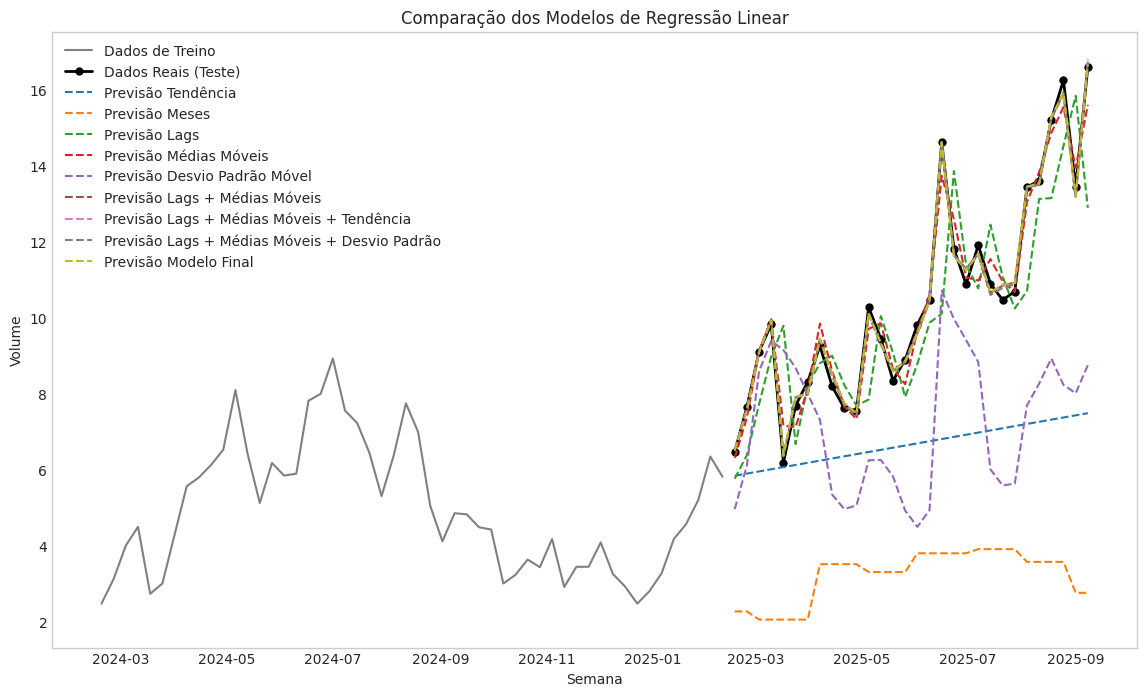

In [14]:
# Visualização e Avaliação Final

plt.figure(figsize=(14, 8))
plt.plot(y_train.iloc[-52:], label='Dados de Treino', color='gray')

plt.plot(
    y_test,
    label='Dados Reais (Teste)',
    color='black',
    linewidth=2,
    marker='o',
    markersize=5,
)

for name, forecast in predictions.items():
    plt.plot(forecast, label=f'Previsão {name}', linestyle='--')

plt.title('Comparação dos Modelos de Regressão Linear')
plt.xlabel('Semana')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.grid(False)

plt.show()

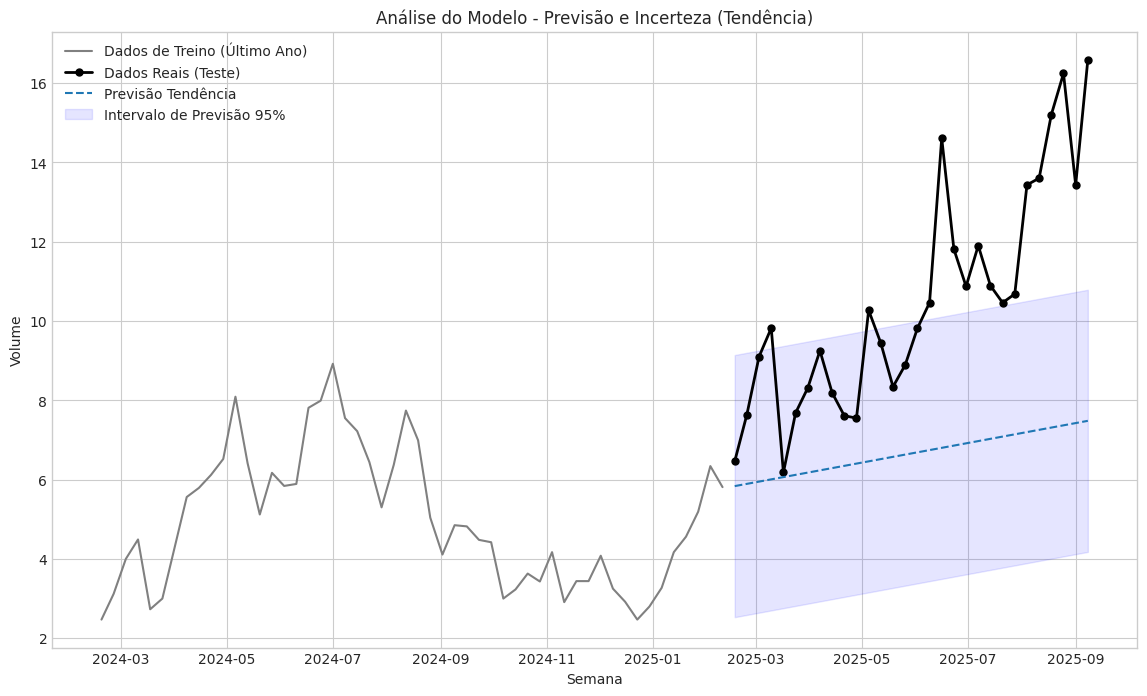

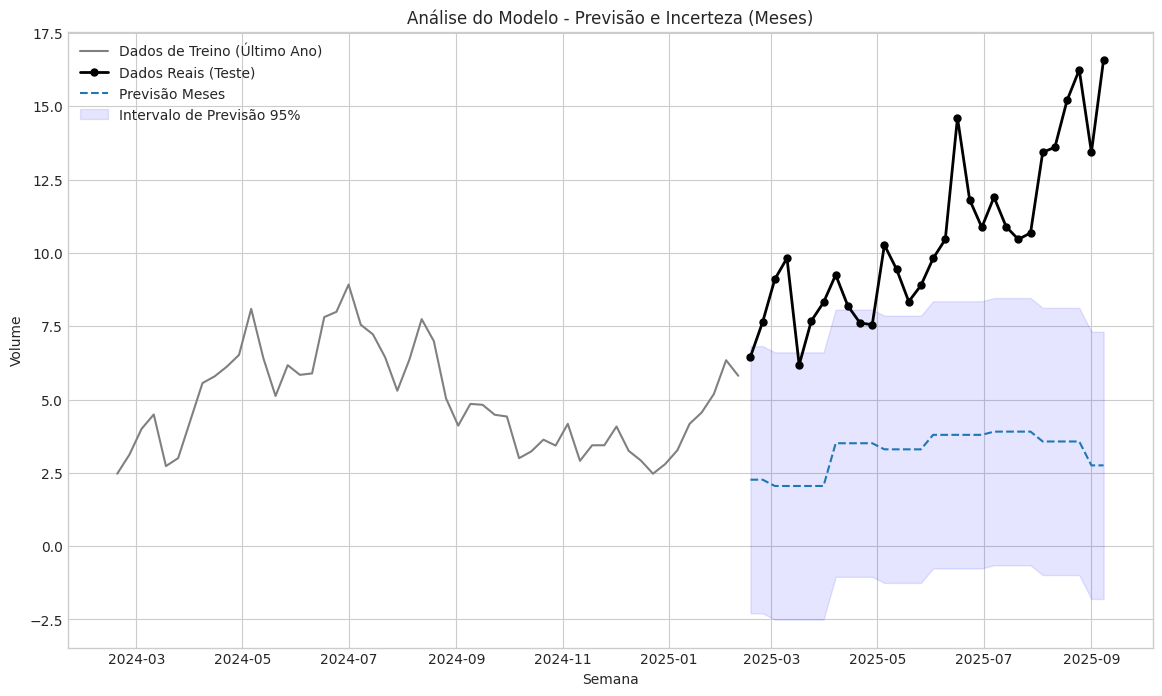

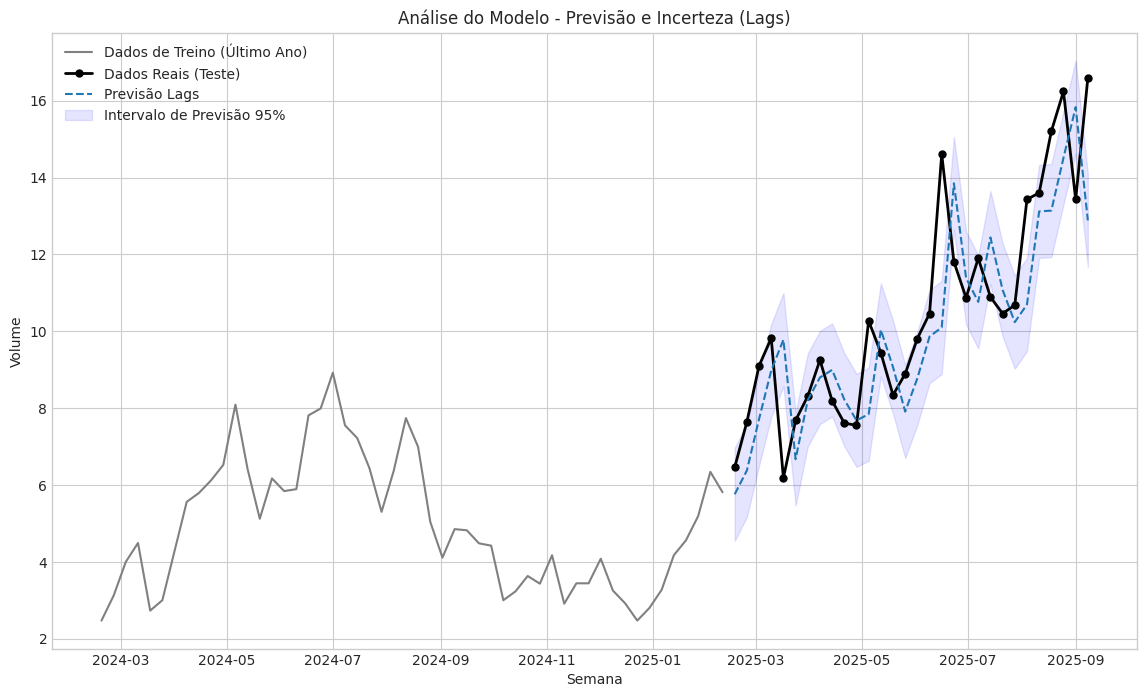

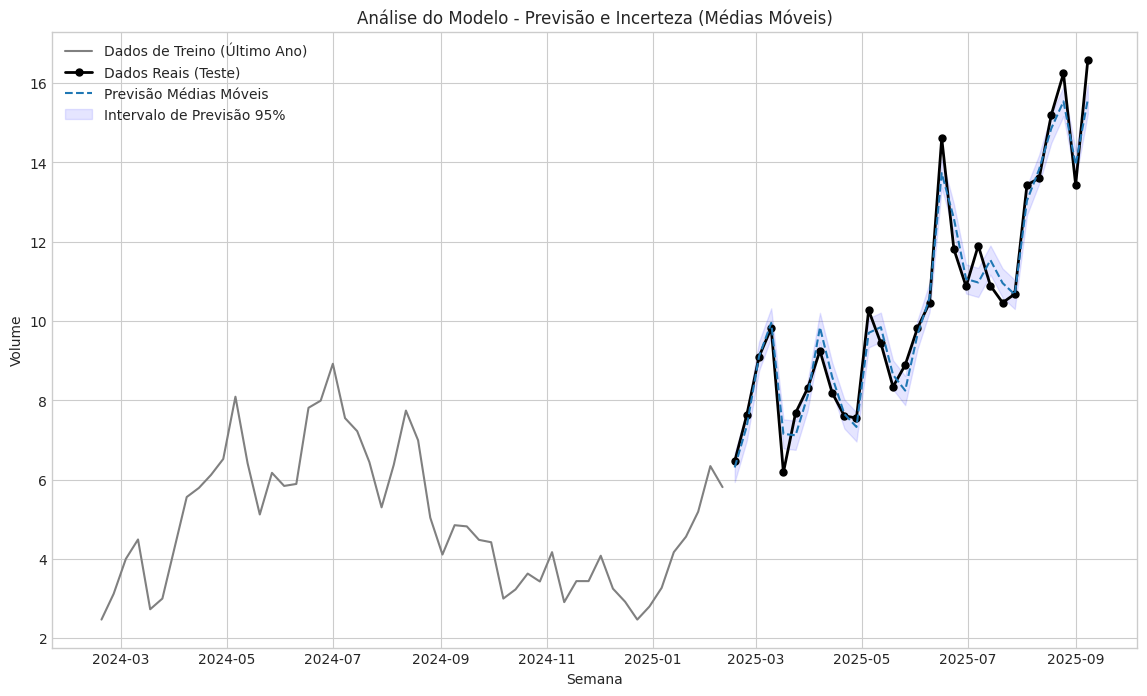

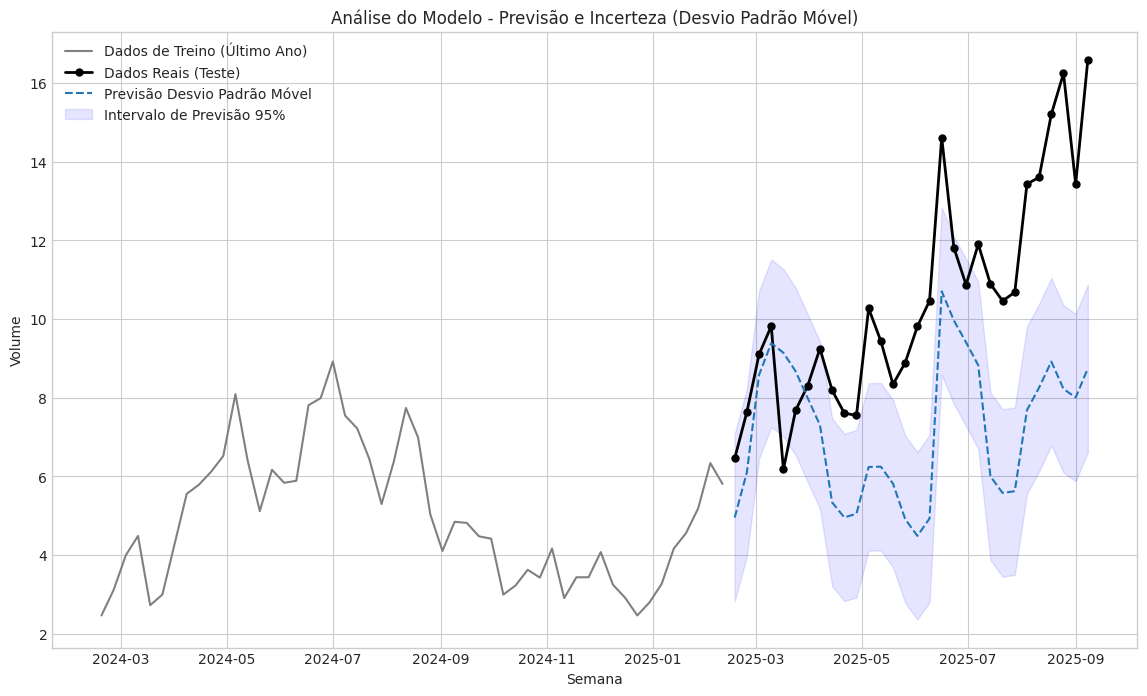

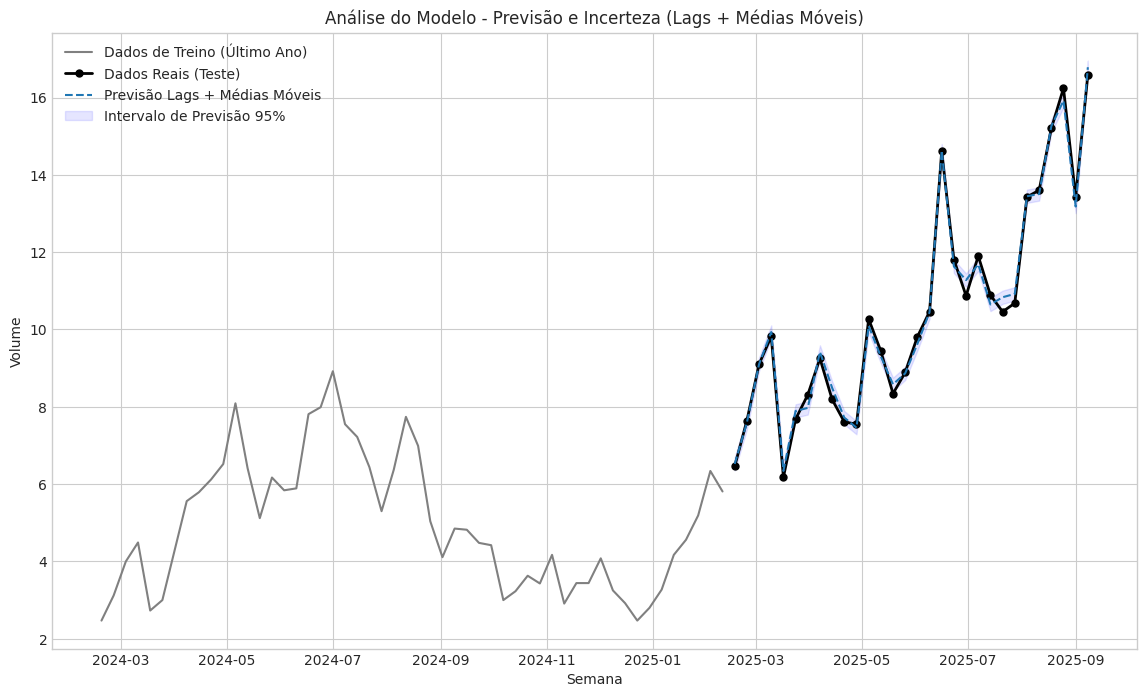

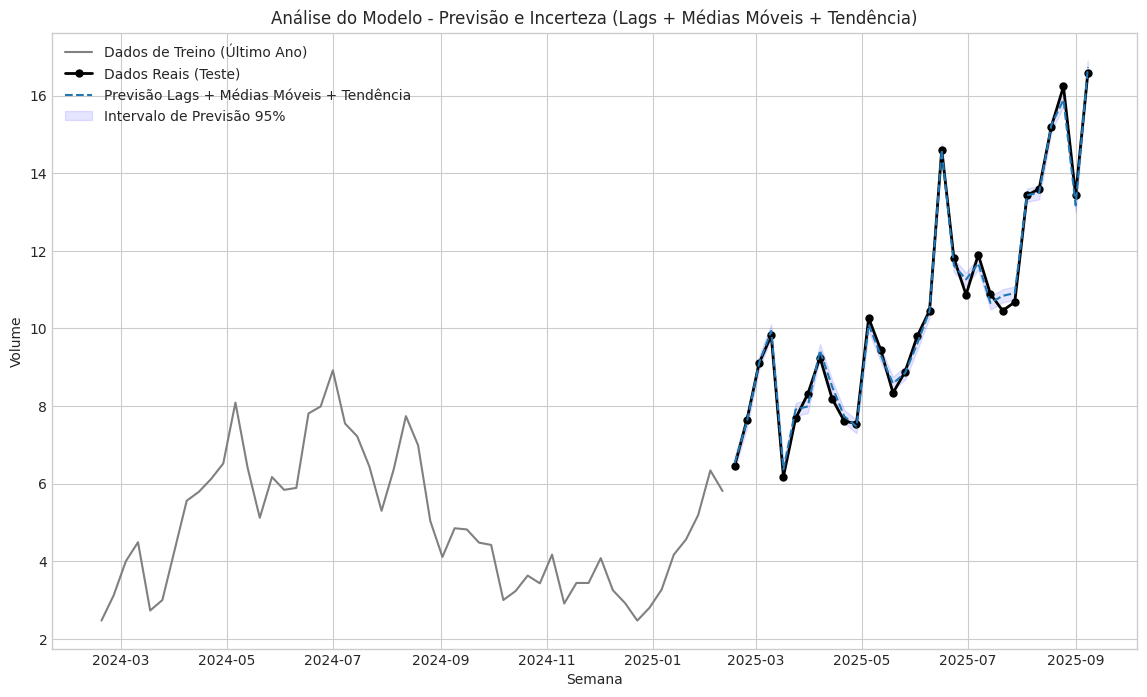

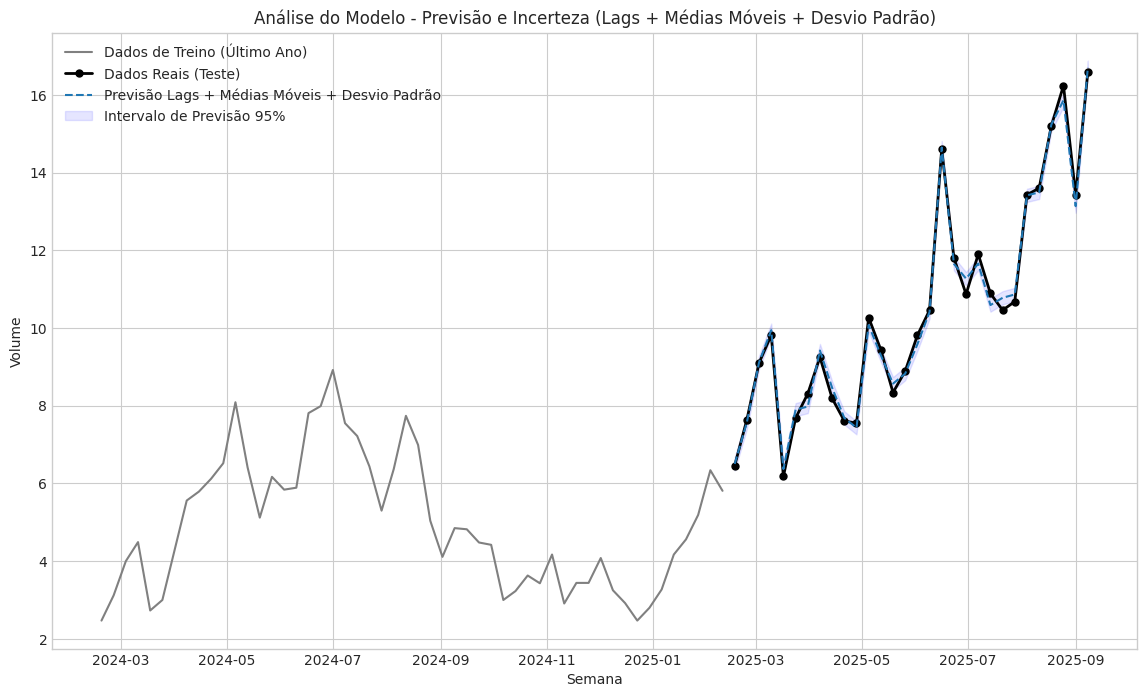

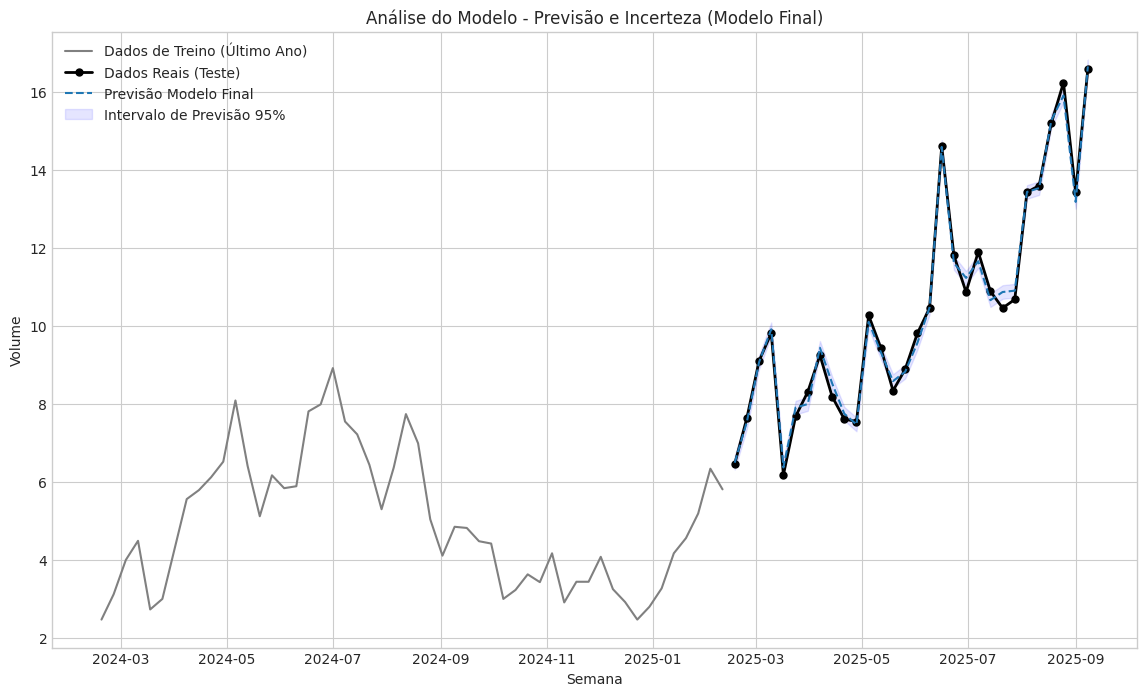

In [15]:
model_names = models.keys()

for name in model_names:
    plt.figure(figsize=(14, 8))

    plt.plot(
        y_train.iloc[-52:], label='Dados de Treino (Último Ano)', color='gray'
    )
    plt.plot(
        y_test,
        label='Dados Reais (Teste)',
        color='black',
        linewidth=2,
        marker='o',
        markersize=5,
    )

    forecast_to_plot = predictions[name]
    interval_to_plot = intervals[name]

    plt.plot(forecast_to_plot, label=f'Previsão {name}', linestyle='--')

    plt.fill_between(
        interval_to_plot['lower'].index,
        interval_to_plot['lower'],
        interval_to_plot['upper'],
        color='blue',
        alpha=0.1,
        label='Intervalo de Previsão 95%',
    )

    plt.title(f'Análise do Modelo - Previsão e Incerteza ({name})')
    plt.xlabel('Semana')
    plt.ylabel('Volume')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.show()

Por fim, visualizamos os resultados do modelo final, que apresentou um desempenho muito bom, todos os parâmetros estatisticamente significativos. Além disso, o modelo conseguiu capturar a maioria dos padrões da série temporal.